In [3]:
!pip install -r requirements.txt 

In [4]:
import pandas as pd
from PIL import Image, ImageChops
import numpy as np
import torch
from lib.ImageFIlter import treat_image_PIL
from sklearn.model_selection import KFold
from torch.utils.data import  DataLoader, TensorDataset, Dataset
from torch import nn
import timm
from tqdm.notebook import tqdm
import torch.optim as optim
import os

## Funcao de filtro de imagem

In [5]:
from PIL import Image, ImageChops
import numpy as np
import os
import shutil
import io
from pathlib import Path
path = '/home/leo/Documents/ecg_classifier/dataset/database_ptbxl/'
def treat_image_PIL(img_path, type_return=2):
    ''''
    Input: Img_path, type return.

    Img_path: path da imagem em formato png, img...
    type_return: 1-> retorno como PIL. 
                2 ou sem type_return -> retorno como numpy array tipo uint8

    Output:
    '''
    im = Image.open(path+img_path) 
    
    # Size of the image in pixels (size of original image) 
    # (This is not mandatory) 
    width, height = im.size 

    rgb =Image.Image.split(im) 

    data =rgb
    b= data[0]
    g= data[1]
    r= data[2]
    #img_out = b+g+.5*r
    #img_out_2 = img_out[500:1600, 50:2100] 

    newsize = (256, 256)
   # im3 =ImageChops.subtract(mask,b, scale=1.0, offset=0)

    b1 = b.crop((120,500,2100,1600))
    g1 = g.crop((120,500,2100,1600))
    r1 = r.crop((120,500,2100,1600))
    im1 = b1.resize(newsize, Image.Resampling.LANCZOS).convert('L')
    im2 = g1.resize(newsize, Image.Resampling.LANCZOS).convert('L')
    im3 = r1.resize(newsize, Image.Resampling.LANCZOS).convert('L')
    if type_return ==1:
        return im1 
    else:
        return np.array([im1,im2,im3],dtype=np.uint8)


def save_file_to_dir(file_obj, directory, filename):
    """
    Save a file to `directory` with the given `filename`.

    Parameters
    - file_obj: a PIL Image, a filesystem path (str or Path) to an existing file,
                bytes/bytearray, or a file-like object with a .read() method.
    - directory: target directory where the file will be saved.
    - filename: the name to use for the saved file (including extension if desired).

    Returns
    - full path (str) to the saved file.

    Raises
    - FileNotFoundError if a provided source path does not exist.
    - ValueError if the provided file_obj type is unsupported.
    """
    os.makedirs(directory, exist_ok=True)
    dest = os.path.join(directory, filename)

    # PIL Image
    if isinstance(file_obj, Image.Image):
        file_obj.save(dest)
        return dest

    # Path-like or string pointing to an existing file
    if isinstance(file_obj, (str, Path)):
        src = str(file_obj)
        if os.path.exists(src):
            shutil.copy(src, dest)
            return dest
        raise FileNotFoundError(f"Source path not found: {src}")

    # File-like object
    if hasattr(file_obj, "read"):
        data = file_obj.read()
        # If read() returned bytes -> try open as image, otherwise write raw
        if isinstance(data, (bytes, bytearray)):
            try:
                img = Image.open(io.BytesIO(data))
                img.save(dest)
                return dest
            except Exception:
                with open(dest, "wb") as f:
                    f.write(data)
                return dest
        else:
            # assume text
            with open(dest, "w", encoding="utf-8") as f:
                f.write(data)
            return dest

    # Raw bytes
    if isinstance(file_obj, (bytes, bytearray)):
        try:
            img = Image.open(io.BytesIO(file_obj))
            img.save(dest)
            return dest
        except Exception:
            with open(dest, "wb") as f:
                f.write(file_obj)
            return dest

    raise ValueError("file_obj must be a PIL.Image, path string/Path, bytes or file-like object")

## Funcoes output_metricas

In [6]:
import os
## Cria funcao para validar se pasta a ser inserida existe. Caso nao exista, cria a pasta
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f'Pasta {folder_path} criada.')
    else:
        print(f'Pasta {folder_path} ja existe.')


## Funcoes subset

In [7]:
from torch.utils.data import  Dataset

class Subset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)

    @property
    def classes(self):
        return self.data.classes

    def shape(self):
        return self.dataset

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cuda:0


## Funcoes simple_loop

In [9]:
import torch
from torch import nn
import numpy as np
import os
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

def salvar_model(model, path = 'output/modelos', name_file='model.pth'):
    create_folder_if_not_exists(path)

    full_path = os.path.join(path, name_file)
    torch.save(model.state_dict(), full_path)

def salvar_metricas(path, name_file_train='train_loss_total.npy', name_file_val='val_loss_total.npy',predict_label=None, true_label=None):
    create_folder_if_not_exists(path)
    full_path_train = os.path.join(path, name_file_train)
    full_path_val = os.path.join(path, name_file_val)
    np.save(full_path_train, np.array(predict_label))
    np.save(full_path_val, np.array(true_label))
    print(f'Metricas salvas em {path} com os nomes {name_file_train} e {name_file_val} e tamanhos {np.array(predict_label).shape} e {np.array(true_label).shape}')

def simple_loop(model, train_image, val_image, epochs, batch_size, fold_index):
    # Simple training loop
    num_epochs = epochs
    train_losses, val_losses = [], []
    lim_loss = 1.5
    iter_size = batch_size
    print(f'Number of training images per iteration: {iter_size}')
    #model = modelo( num_classes=5)
  # model.to(device)
    #criterion =  nn.NLLLoss()
    criterion =  nn.BCEWithLogitsLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    predict_label_full_train = []
    predict_label_full = []
    true_label_full_train = []
    true_label_full = []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        predict_label_train =[]
        true_label_train =[]
        running_loss_train = 0.0
        for images, labels in tqdm(train_image, desc='Training loop'):
            # Move inputs and labels to the device
            images = images.to(torch.float)
            image, label = images, labels
            optimizer.zero_grad()
            outputs = model(image)
            #loss_train = criterion(outputs.float(), label.float())
            loss_train = criterion(outputs, label)
            loss_train.backward()
            optimizer.step()
            running_loss_train += loss_train.item() * label.size(0)
            try:
                _pred_train = outputs.cpu().data.numpy().astype(int).T[0].tolist()
                if(len(_pred_train) == iter_size):
                    predict_label_train.append(_pred_train)
                    _true_train = label.cpu().data.numpy().astype(int).T[0].tolist()
                    true_label_train.append(_true_train)

            except Exception as e:
                print(f"Concatenation error iter: {e}")
                print(_pred_train)
                print(predict_label_train)    
        train_loss = running_loss_train / len(train_image.dataset)
        train_losses.append(train_loss)
        try:
            _p_train = predict_label_train
            _t_train = true_label_train
            predict_label_full_train.append(_p_train)
            true_label_full_train.append(_t_train)
        except Exception as e:
            print(f"Concatenation error full: {e}")
            print(predict_label_train)
            print(true_label_train)
        model.eval()
        running_loss_valid = 0.0
        rotulos =[] 
        predict_label =[]
        true_label =[]
        _iter=0
        with torch.no_grad():
            for images, labels in tqdm(val_image, desc='Validation loop'):
                # Move inputs and labels to the device
                images = images.to(torch.float)
                images, label = images, labels
                rotulos.append(label.cpu().data.numpy())
                outputs = model(images)
                #loss_valid = criterion(outputs.float(), label.float())
                loss_valid = criterion(outputs, label)

                #print( [outputs.cpu().data.numpy().astype(int).T[0]])
                #print(label.cpu().data.numpy().astype(int).T[0])
                #print(predict_label)
                try:
                    _pred = outputs.cpu().data.numpy().astype(int).T[0].tolist()

                    if(len(_pred) == iter_size):
                        predict_label.append(_pred)
                        _true = label.cpu().data.numpy().astype(int).T[0].tolist()
                        true_label.append(_true)
                except Exception as e:
                    print(f"Concatenation error iter: {e}")
                    print(_pred)
                    print(predict_label)    
                running_loss_valid += loss_valid.item() * label.size(0)
                _iter +=1
        val_loss = running_loss_valid / len(val_image.dataset)
        val_losses.append(val_loss)
        print(f'End validation for epoch {epoch}')
        print(f'Amount of images validated: {val_image}')
        print(f'Label predict shape : {len(predict_label)} for epoch {epoch}')
        print(f'Count of iterations: {_iter} for epoch {epoch}')
        try:
            _p = predict_label
            _t = true_label
            predict_label_full.append(_p)
            true_label_full.append(_t)
        except Exception as e:
            print(f"Concatenation error full: {e}")
            print(predict_label)
            print(true_label)
        #val_acc = accuracy_score(rotulos,output_model)
        print(f'Val accuracy {epoch}:')
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

    predict_label_full_out = np.array(predict_label_full)
    true_label_full_out = np.array(true_label_full)
    predict_label_full_train_out = np.array(predict_label_full_train)
    true_label_full_train_out = np.array(true_label_full_train)
    print(f'Salvado das metricas de validacao e treino')
    salvar_metricas(path=f'output/metricas/valid/fold_{fold_index}', name_file_train=f'predict_label_valid_fold_{fold_index}.npy', name_file_val=f'true_label_valid_fold_{fold_index}.npy', predict_label= predict_label_full_out, true_label= true_label_full_out)
    salvar_metricas(path=f'output/metricas/train/fold_{fold_index}', name_file_train=f'predict_label_train_fold_{fold_index}.npy', name_file_val=f'true_label_train_fold_{fold_index}.npy', predict_label= predict_label_full_train_out, true_label= true_label_full_train_out)
    print(f'Finalizado o salvamento das metricas')
    return train_losses, val_losses, model,predict_label_full_out, true_label_full_out

Device: cuda:0


## Funcao Modelo ECG Resnet

In [10]:
#from models import ECGClassifierResnet
from torch import nn
import timm
class ECGClassifierResnet(nn.Module):
    def __init__(self, num_classes=1):
        super(ECGClassifierResnet, self).__init__()
        # Where we define all the parts of the model
        #self.base_model = timm.create_model('efficientnet_b0', pretrained=True) 
        self.base_model=timm.create_model('resnet50d.ra4_e3600_r224_in1k',pretrained=True)
        #self.base_model = timm.create_model('vit_mediumd_patch16_reg4_gap_256.sbb2_e200_in12k_ft_in1k',num_classes=5,pretrained=True)


        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 2048        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size,1)
        ) # saida como Sigmoid multilabel

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        #output = nn.Softmax(dim=1)(output)
        return output

## Arquivo Main.py - Orquestrador

In [11]:

FILE_PATH = 'norm_outros_dataset.csv'


print("Iniciando o programa...")
print("Parametros de Execucao:")
folds = 5
epochs = 20
BATCH_SIZE = 10
flg_salvar_modelos = True

print(f"  Numero de folds para K-Fold Cross Validation: {folds}")

print(f"  Tamanho do batch para treinamento: {BATCH_SIZE}")

print(f"  Numero de epocas para treinamento: {epochs}")


Iniciando o programa...
Parametros de Execucao:
  Numero de folds para K-Fold Cross Validation: 5
  Tamanho do batch para treinamento: 10
  Numero de epocas para treinamento: 20


### Geracao do tensor

In [18]:


print(f"Leitura dos dados no arquivo '{FILE_PATH}'...")

data = pd.read_csv(FILE_PATH)
data = data.sample(n=500, random_state=42).reset_index(drop=True)  # Embaralha e seleciona 2000 amostras
data.rename(columns={data.columns[0]:'path'}, inplace=True)
data.rename(columns={data.columns[1]:'label'}, inplace=True)
print("Dados lidos com sucesso. Tamnaho dos dados:", data.shape)

print("Geracao Tensor de Imagens...")
## Loop
img_dataset = np.ones((data.shape[0],3,256,256),dtype=np.uint8)

j=0
for i in tqdm(data['path'], desc='Processing images'):
    img_dataset[j]=treat_image_PIL(i,2)
    j+=1
tensor_imagem = torch.tensor(img_dataset)
print("Tensor de Imagens gerado com sucesso. Tamanho do Tensor:", tensor_imagem.shape)




Leitura dos dados no arquivo 'norm_outros_dataset.csv'...
Dados lidos com sucesso. Tamnaho dos dados: (500, 2)
Geracao Tensor de Imagens...


Processing images: 100%|██████████| 500/500 [00:28<00:00, 17.76it/s]

Tensor de Imagens gerado com sucesso. Tamanho do Tensor: torch.Size([500, 3, 256, 256])


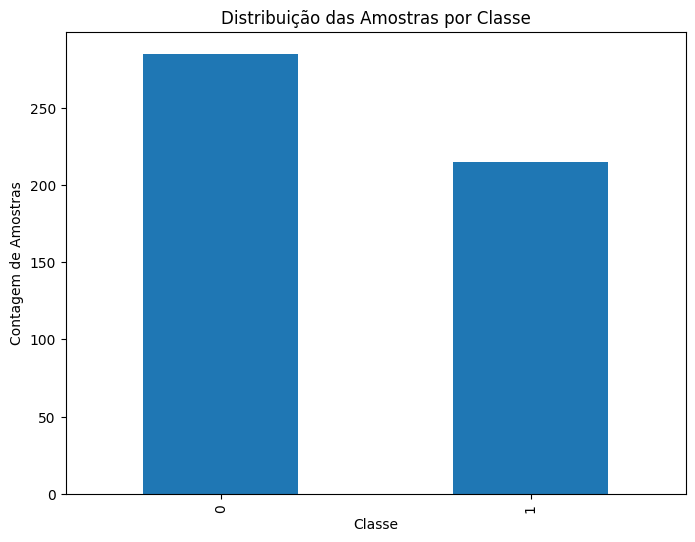

In [19]:
## Distribuicao das amostras
## Histograma da distribuicao das amostras
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  
data['label'].value_counts().plot(kind='bar')
plt.title('Distribuição das Amostras por Classe')
plt.xlabel('Classe')
plt.ylabel('Contagem de Amostras')
plt.show()

In [20]:
img1 = tensor_imagem[0][0]
len(img1[0])

256

### Geracao de rótulos para classificação

Colunas utilizadas para classificacao (Labels)

labels = [ OCA, NOCA]

In [21]:

print("Tensor de Rotulos sendo gerado...")


tensor_label = torch.tensor(np.array(data['label'].astype("float32"))).unsqueeze(1)
print("Tensor de Rotulos gerado com sucesso. Tamanho do Tensor:", tensor_label.shape)

print(f"Configuracao do K-Fold para {folds} folds...")
kf = KFold(n_splits=folds)
kf.get_n_splits(tensor_imagem)
print(kf)
print("K-Fold configurado com sucesso.")

print("Iniciando o treinamento com K-Fold Cross Validation...")

train_loss_total = []
val_loss_total =[]
all_models =[]

train_dataset = TensorDataset(tensor_imagem, tensor_label)


Tensor de Rotulos sendo gerado...
Tensor de Rotulos gerado com sucesso. Tamanho do Tensor: torch.Size([500, 1])
Configuracao do K-Fold para 5 folds...
KFold(n_splits=5, random_state=None, shuffle=False)
K-Fold configurado com sucesso.
Iniciando o treinamento com K-Fold Cross Validation...


## Train - Valid Loop

Fluxo de treinamento

Input: modelo, dataloader_train, dataloader_teste , epocas.
- Para cada epoca

    - treinamento:

        - para cada batch (lote de imagens) no dataloader_train: (executo para todo o dataloader)
            
            leitura das imagens e rotulos. 
            
            prediz o rotulo (outputs): rotulos preditos para o tamanho do batch (ex: para um batch de 10, o 
            output tem tamanho 10)
            
            calcula o Loss () 
            
            aplica o backward -> Ajuste dos pesos nos neuronios de acordo com o valor de loss (w_{i})

            otimizo o modelo com optimizer.step()

    - validacao (avaliacao do desempenho para aquele conjunto de treinamento):
        - para cada batch (lote de imagens) no dataloader_train: (executo para todo o dataloader)

            leitura das imagens e rotulos.

            prediz o rotulo (outputs): rotulos preditos para o tamanho do batch (ex: para um batch de 10, o 
            output tem tamanho 10)
            
            calcula o Loss ()


    - Calculo de metricas de loss media de validacao.

    - Calculo de metrica de loss media de treinamento. 

    - Print de metricas de desempenho para a epoca. 








In [22]:
## create first model.
print('''
      ###############################################
      Inicio do treinamento com K-Fold Cross Validation
      ###############################################
      ''')
device = 'cuda:0'
    

for i, (train_index, test_index) in enumerate(kf.split(train_dataset)):
    print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={test_index}")
    ## init train test for folder
    train_dataset_part = Subset( train_dataset, train_index)
    val_dataset_part = Subset( train_dataset, test_index)

    train_loader_img = DataLoader(train_dataset_part, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_img = DataLoader(val_dataset_part, batch_size=BATCH_SIZE, shuffle=True)

    model= ECGClassifierResnet( num_classes=1)
    if (flg_salvar_modelos):
        salvar_model(model, path='output/modelos', name_file=f'model_fold_{i}.pth')
    print(f'Train and valid for Fold {i}')
    t, l,_,outputs,labels = simple_loop(model, train_loader_img,val_loader_img, epochs, batch_size = BATCH_SIZE, fold_index =i)
    ## Evaluate model.
    train_loss_total.append(t)
    val_loss_total.append(l)

print('''
      ###############################################
      Fim do treinamento com K-Fold Cross Validation
      ###############################################
      ''')
print("Treinamento com K-Fold Cross Validation concluído com sucesso.")


      ###############################################
      Inicio do treinamento com K-Fold Cross Validation
      ###############################################
      
Fold 0:
Pasta output/modelos ja existe.
Train and valid for Fold 0
Number of training images per iteration: 10


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


End validation for epoch 0
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 0
Count of iterations: 10 for epoch 0
Val accuracy 0:
Epoch 1/20 - Train loss: 0.6226688556373119, Validation loss: 0.6500192761421204


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


End validation for epoch 1
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 1
Count of iterations: 10 for epoch 1
Val accuracy 1:
Epoch 2/20 - Train loss: 0.42333133667707445, Validation loss: 0.47255601584911344


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


End validation for epoch 2
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 2
Count of iterations: 10 for epoch 2
Val accuracy 2:
Epoch 3/20 - Train loss: 0.2817439349368215, Validation loss: 0.8266502618789673


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


End validation for epoch 3
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 3
Count of iterations: 10 for epoch 3
Val accuracy 3:
Epoch 4/20 - Train loss: 0.16920238304883242, Validation loss: 0.3177190013229847


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


End validation for epoch 4
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 4
Count of iterations: 10 for epoch 4
Val accuracy 4:
Epoch 5/20 - Train loss: 0.1668956853915006, Validation loss: 0.3651444710791111


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


End validation for epoch 5
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 5
Count of iterations: 10 for epoch 5
Val accuracy 5:
Epoch 6/20 - Train loss: 0.10288798869587482, Validation loss: 0.6746343493461608


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


End validation for epoch 6
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 6
Count of iterations: 10 for epoch 6
Val accuracy 6:
Epoch 7/20 - Train loss: 0.1881891414988786, Validation loss: 0.7692739456892014


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


End validation for epoch 7
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 7
Count of iterations: 10 for epoch 7
Val accuracy 7:
Epoch 8/20 - Train loss: 0.0954435046762228, Validation loss: 0.4083130367100239


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


End validation for epoch 8
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 8
Count of iterations: 10 for epoch 8
Val accuracy 8:
Epoch 9/20 - Train loss: 0.0626867852639407, Validation loss: 0.5523463617544622


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


End validation for epoch 9
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 9
Count of iterations: 10 for epoch 9
Val accuracy 9:
Epoch 10/20 - Train loss: 0.06132043356774375, Validation loss: 0.38904706239700315


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


End validation for epoch 10
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 10
Count of iterations: 10 for epoch 10
Val accuracy 10:
Epoch 11/20 - Train loss: 0.07772338854847476, Validation loss: 0.4675698548555374


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


End validation for epoch 11
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 11
Count of iterations: 10 for epoch 11
Val accuracy 11:
Epoch 12/20 - Train loss: 0.11305534420534968, Validation loss: 0.3102650910615921


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


End validation for epoch 12
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 12
Count of iterations: 10 for epoch 12
Val accuracy 12:
Epoch 13/20 - Train loss: 0.12853765052277594, Validation loss: 0.5247785031795502


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


End validation for epoch 13
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 13
Count of iterations: 10 for epoch 13
Val accuracy 13:
Epoch 14/20 - Train loss: 0.06455387582536787, Validation loss: 0.4705077961087227


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


End validation for epoch 14
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 14
Count of iterations: 10 for epoch 14
Val accuracy 14:
Epoch 15/20 - Train loss: 0.07574830492958426, Validation loss: 0.39917593225836756


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


End validation for epoch 15
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 15
Count of iterations: 10 for epoch 15
Val accuracy 15:
Epoch 16/20 - Train loss: 0.059681017376715315, Validation loss: 0.538015303760767


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


End validation for epoch 16
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 16
Count of iterations: 10 for epoch 16
Val accuracy 16:
Epoch 17/20 - Train loss: 0.04154044054739643, Validation loss: 0.4300541512668133


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


End validation for epoch 17
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 17
Count of iterations: 10 for epoch 17
Val accuracy 17:
Epoch 18/20 - Train loss: 0.08167378652724437, Validation loss: 0.4628206742927432


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


End validation for epoch 18
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 18
Count of iterations: 10 for epoch 18
Val accuracy 18:
Epoch 19/20 - Train loss: 0.03611294325964991, Validation loss: 0.5136280605569482


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


End validation for epoch 19
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4f9536650>
Label predict shape : 10 for epoch 19
Count of iterations: 10 for epoch 19
Val accuracy 19:
Epoch 20/20 - Train loss: 0.024875717506802175, Validation loss: 0.5597770504653454
Salvado das metricas de validacao e treino
Pasta output/metricas/valid/fold_0 ja existe.
Metricas salvas em output/metricas/valid/fold_0 com os nomes predict_label_valid_fold_0.npy e true_label_valid_fold_0.npy e tamanhos (20, 10, 10) e (20, 10, 10)
Pasta output/metricas/train/fold_0 ja existe.
Metricas salvas em output/metricas/train/fold_0 com os nomes predict_label_train_fold_0.npy e true_label_train_fold_0.npy e tamanhos (20, 40, 10) e (20, 40, 10)
Finalizado o salvamento das metricas
Fold 1:
Pasta output/modelos ja existe.
Train and valid for Fold 1
Number of training images per iteration: 10


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


End validation for epoch 0
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 0
Count of iterations: 10 for epoch 0
Val accuracy 0:
Epoch 1/20 - Train loss: 0.6209552764892579, Validation loss: 0.6854379594326019


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


End validation for epoch 1
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 1
Count of iterations: 10 for epoch 1
Val accuracy 1:
Epoch 2/20 - Train loss: 0.33252842612564565, Validation loss: 0.5557798832654953


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


End validation for epoch 2
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 2
Count of iterations: 10 for epoch 2
Val accuracy 2:
Epoch 3/20 - Train loss: 0.22418878013268112, Validation loss: 0.7513783678412438


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


End validation for epoch 3
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 3
Count of iterations: 10 for epoch 3
Val accuracy 3:
Epoch 4/20 - Train loss: 0.09652427835389972, Validation loss: 0.47077207565307616


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


End validation for epoch 4
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 4
Count of iterations: 10 for epoch 4
Val accuracy 4:
Epoch 5/20 - Train loss: 0.07976440746570006, Validation loss: 0.5681142896413803


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


End validation for epoch 5
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 5
Count of iterations: 10 for epoch 5
Val accuracy 5:
Epoch 6/20 - Train loss: 0.1984153866302222, Validation loss: 1.5051294267177582


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


End validation for epoch 6
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 6
Count of iterations: 10 for epoch 6
Val accuracy 6:
Epoch 7/20 - Train loss: 0.11809288874501363, Validation loss: 1.1346247136592864


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


End validation for epoch 7
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 7
Count of iterations: 10 for epoch 7
Val accuracy 7:
Epoch 8/20 - Train loss: 0.11669749721186236, Validation loss: 0.8818129643797874


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


End validation for epoch 8
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 8
Count of iterations: 10 for epoch 8
Val accuracy 8:
Epoch 9/20 - Train loss: 0.10925816134549678, Validation loss: 0.7834086388349533


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


End validation for epoch 9
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 9
Count of iterations: 10 for epoch 9
Val accuracy 9:
Epoch 10/20 - Train loss: 0.09430404508020729, Validation loss: 0.6449060723185539


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


End validation for epoch 10
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 10
Count of iterations: 10 for epoch 10
Val accuracy 10:
Epoch 11/20 - Train loss: 0.08252326825167984, Validation loss: 0.5261526353657245


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


End validation for epoch 11
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 11
Count of iterations: 10 for epoch 11
Val accuracy 11:
Epoch 12/20 - Train loss: 0.059616687113884834, Validation loss: 0.7090119481086731


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


End validation for epoch 12
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 12
Count of iterations: 10 for epoch 12
Val accuracy 12:
Epoch 13/20 - Train loss: 0.09235975123010576, Validation loss: 0.6385903431102633


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


End validation for epoch 13
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 13
Count of iterations: 10 for epoch 13
Val accuracy 13:
Epoch 14/20 - Train loss: 0.04613861157558859, Validation loss: 0.5859310440719128


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


End validation for epoch 14
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 14
Count of iterations: 10 for epoch 14
Val accuracy 14:
Epoch 15/20 - Train loss: 0.05150132927519735, Validation loss: 0.7325790509581566


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


End validation for epoch 15
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 15
Count of iterations: 10 for epoch 15
Val accuracy 15:
Epoch 16/20 - Train loss: 0.03699542532558553, Validation loss: 0.8025525329168886


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


End validation for epoch 16
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 16
Count of iterations: 10 for epoch 16
Val accuracy 16:
Epoch 17/20 - Train loss: 0.09257306091021747, Validation loss: 0.7067226227372885


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


End validation for epoch 17
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 17
Count of iterations: 10 for epoch 17
Val accuracy 17:
Epoch 18/20 - Train loss: 0.06780485596391372, Validation loss: 0.5635670138522982


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


End validation for epoch 18
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 18
Count of iterations: 10 for epoch 18
Val accuracy 18:
Epoch 19/20 - Train loss: 0.07037575648573693, Validation loss: 0.5608493149280548


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


End validation for epoch 19
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4eebccef0>
Label predict shape : 10 for epoch 19
Count of iterations: 10 for epoch 19
Val accuracy 19:
Epoch 20/20 - Train loss: 0.026840622059535236, Validation loss: 0.8041184782981873
Salvado das metricas de validacao e treino
Pasta output/metricas/valid/fold_1 ja existe.
Metricas salvas em output/metricas/valid/fold_1 com os nomes predict_label_valid_fold_1.npy e true_label_valid_fold_1.npy e tamanhos (20, 10, 10) e (20, 10, 10)
Pasta output/metricas/train/fold_1 ja existe.
Metricas salvas em output/metricas/train/fold_1 com os nomes predict_label_train_fold_1.npy e true_label_train_fold_1.npy e tamanhos (20, 40, 10) e (20, 40, 10)
Finalizado o salvamento das metricas
Fold 2:
Pasta output/modelos ja existe.
Train and valid for Fold 2
Number of training images per iteration: 10


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


End validation for epoch 0
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 0
Count of iterations: 10 for epoch 0
Val accuracy 0:
Epoch 1/20 - Train loss: 0.6109098479151726, Validation loss: 0.49030978977680206


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


End validation for epoch 1
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 1
Count of iterations: 10 for epoch 1
Val accuracy 1:
Epoch 2/20 - Train loss: 0.3603760164231062, Validation loss: 0.4627368912100792


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


End validation for epoch 2
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 2
Count of iterations: 10 for epoch 2
Val accuracy 2:
Epoch 3/20 - Train loss: 0.21005564099177718, Validation loss: 0.6986100852489472


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


End validation for epoch 3
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 3
Count of iterations: 10 for epoch 3
Val accuracy 3:
Epoch 4/20 - Train loss: 0.15529567962512375, Validation loss: 0.9981987059116364


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


End validation for epoch 4
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 4
Count of iterations: 10 for epoch 4
Val accuracy 4:
Epoch 5/20 - Train loss: 0.167246906994842, Validation loss: 0.5803611010313035


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


End validation for epoch 5
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 5
Count of iterations: 10 for epoch 5
Val accuracy 5:
Epoch 6/20 - Train loss: 0.15517274644225837, Validation loss: 0.46312612295150757


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


End validation for epoch 6
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 6
Count of iterations: 10 for epoch 6
Val accuracy 6:
Epoch 7/20 - Train loss: 0.15785675516817718, Validation loss: 0.9535885334014893


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


End validation for epoch 7
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 7
Count of iterations: 10 for epoch 7
Val accuracy 7:
Epoch 8/20 - Train loss: 0.09008279934059829, Validation loss: 0.5231178224086761


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


End validation for epoch 8
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 8
Count of iterations: 10 for epoch 8
Val accuracy 8:
Epoch 9/20 - Train loss: 0.06374903805553914, Validation loss: 0.611599975079298


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


End validation for epoch 9
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 9
Count of iterations: 10 for epoch 9
Val accuracy 9:
Epoch 10/20 - Train loss: 0.10750417839735746, Validation loss: 0.5999389171600342


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


End validation for epoch 10
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 10
Count of iterations: 10 for epoch 10
Val accuracy 10:
Epoch 11/20 - Train loss: 0.059472394839394836, Validation loss: 0.6573609948158264


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


End validation for epoch 11
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 11
Count of iterations: 10 for epoch 11
Val accuracy 11:
Epoch 12/20 - Train loss: 0.07745183563965838, Validation loss: 0.6349450526759028


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


End validation for epoch 12
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 12
Count of iterations: 10 for epoch 12
Val accuracy 12:
Epoch 13/20 - Train loss: 0.06055542229150888, Validation loss: 0.8247234217822552


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


End validation for epoch 13
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 13
Count of iterations: 10 for epoch 13
Val accuracy 13:
Epoch 14/20 - Train loss: 0.04629378519020975, Validation loss: 0.8047408536076546


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


End validation for epoch 14
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 14
Count of iterations: 10 for epoch 14
Val accuracy 14:
Epoch 15/20 - Train loss: 0.13127363114617766, Validation loss: 0.521865026652813


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


End validation for epoch 15
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 15
Count of iterations: 10 for epoch 15
Val accuracy 15:
Epoch 16/20 - Train loss: 0.10456441931892187, Validation loss: 0.7809827940538525


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


End validation for epoch 16
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 16
Count of iterations: 10 for epoch 16
Val accuracy 16:
Epoch 17/20 - Train loss: 0.04286162058124319, Validation loss: 0.6568442532792688


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


End validation for epoch 17
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 17
Count of iterations: 10 for epoch 17
Val accuracy 17:
Epoch 18/20 - Train loss: 0.0555847886542324, Validation loss: 0.6418427899479866


Validation loop: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


End validation for epoch 18
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 18
Count of iterations: 10 for epoch 18
Val accuracy 18:
Epoch 19/20 - Train loss: 0.024346419825451448, Validation loss: 0.7416035577654838


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


End validation for epoch 19
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee6439b0>
Label predict shape : 10 for epoch 19
Count of iterations: 10 for epoch 19
Val accuracy 19:
Epoch 20/20 - Train loss: 0.06037598201146466, Validation loss: 0.7965994425117969
Salvado das metricas de validacao e treino
Pasta output/metricas/valid/fold_2 ja existe.
Metricas salvas em output/metricas/valid/fold_2 com os nomes predict_label_valid_fold_2.npy e true_label_valid_fold_2.npy e tamanhos (20, 10, 10) e (20, 10, 10)
Pasta output/metricas/train/fold_2 ja existe.
Metricas salvas em output/metricas/train/fold_2 com os nomes predict_label_train_fold_2.npy e true_label_train_fold_2.npy e tamanhos (20, 40, 10) e (20, 40, 10)
Finalizado o salvamento das metricas
Fold 3:
Pasta output/modelos ja existe.
Train and valid for Fold 3
Number of training images per iteration: 10


Validation loop: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


End validation for epoch 0
Amount of images validated: <torch.utils.data.dataloader.DataLoader object at 0x75f4ee7fd150>
Label predict shape : 10 for epoch 0
Count of iterations: 10 for epoch 0
Val accuracy 0:
Epoch 1/20 - Train loss: 0.6142537228763103, Validation loss: 0.6568727850914001


Training loop:  28%|██▊       | 11/40 [00:16<00:43,  1.51s/it]


KeyboardInterrupt: 

## Métricas de Avaliacao dos modelos

Acuracia

Precisao

Sensibilidade

Especificidade

F1-Score

In [23]:
#### Leitura de métricas salvas
import numpy as np
predict_label_0 = np.load('output/metricas/train/fold_0/predict_label_train_fold_0.npy')
true_label_0 = np.load('output/metricas/train/fold_0/true_label_train_fold_0.npy')
# --- IGNORE ---
#print(true_label_0[1][0][0])
criterio = nn.BCEWithLogitsLoss()
len(predict_label_0)

20

In [ ]:
true_label_0

array([[[0, 1, 1, 1, 1],
        [1, 1, 1, 0, 0],
        [0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 1, 1],
        [1, 1, 0, 0, 1],
        [1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1],
        [1, 0, 1, 1, 0]],

       [[0, 1, 0, 1, 1],
        [0, 1, 1, 1, 0],
        [1, 1, 0, 0, 1],
        [1, 1, 0, 0, 0],
        [0, 0, 1, 1, 0],
        [1, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 1, 1, 1],
        [0, 1, 1, 1, 0],
        [0, 1, 0, 0, 1]],

       [[0, 0, 0, 1, 1],
        [1, 0, 0, 0, 1],
        [0, 1, 1, 0, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0],
        [1, 0, 1, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1]],

       [[1, 0, 0, 0, 1],
        [1, 0, 0, 1, 0],
        [1, 1, 1, 0, 0],
        [0, 1, 1, 0, 0],
        [1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1],
        [1, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 1, 1, 1],
        [0, 1, 0, 0

In [ ]:
print(predict_label_0)
len(predict_label_0[1])

[[[ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]]

 [[ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]]

 [[ 0  0  0  0  1]
  [ 0  0  0  0  1]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 1  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 1  0  0  0  0]
  [ 0  1  0  0  1]]

 [[ 1  0  0  0  0]
  [ 1  0  0  1  0]
  [ 0  1  1 -1 -1]
  [-1  1  0  0  0]
  [ 0  1  0  0 -1]
  [-1  1 -1  1  1]
  [ 1 -1 -1  0  2]
  [ 0  0  0  0  2]
  [-1  1  0  0  1]
  [-1  1  0  0  1]]

 [[ 1  0 -2  1  1]
  [ 2 -1 -1  3 -1]
  [-2  2  2 -2  2]
  [-1  0  0  3  0]
  [-1  0  0  3  0]
  [ 1  1  0  2 -3]
  [-1  2 -1  3 -1]
  [ 4 -2 -1  3 -2]
  [-2  0  1  2  1]
  [-1  2  2 -2  0]]]


10

In [ ]:
for i in range(len(predict_label_0)):
    outputs_tensor = torch.tensor(predict_label_0[i]).to(torch.float)
    labels_tensor = torch.tensor(true_label_0[i]).to(torch.float)
    loss = criterio(outputs_tensor, labels_tensor)
    print(f'Loss for batch {i}: {loss.item()}')


Loss for batch 0: 0.6931471228599548
Loss for batch 1: 0.6931471228599548
Loss for batch 2: 0.6475609540939331
Loss for batch 3: 0.4805556833744049
Loss for batch 4: 0.2919488847255707


In [ ]:
true_label_0

array([[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1],
       [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]])

In [ ]:
#### Leitura de métricas salvas
import numpy as np
predict_label_0_valid= np.load('/Users/leonardocipriani/Documents/dev/python/Artificial Intelligence Projects/oca-ia/incor_env/output/metricas/valid/fold_0/predict_label_valid_fold_0.npy')
true_label_0_valid= np.load('/Users/leonardocipriani/Documents/dev/python/Artificial Intelligence Projects/oca-ia/incor_env/output/metricas/valid/fold_0/true_label_valid_fold_0.npy')
# --- IGNORE ---
print(predict_label_0_valid)
print(true_label_0_valid)

[[[2821440 2821440 2821440 2821440 2821440]
  [3546063 2821440 2821440 2821440 2821440]
  [2821440 2821440 2821440 2821440 2821440]
  [2821440 2821440 2821440 2821440 4119212]
  [2821440 2821440 3188174 2821440 2821440]
  [2821440 2821440 2821440 2821440 2471002]
  [2821440 2821440 2821440 2821440 2821440]
  [3436914 2821440 2821440 2821440 3913112]
  [2821440 2821440 2821440 2821440 2821440]
  [2821440 2821440 2821440 2821440 2821440]
  [2821440 2821440 3827248 2821440 2821440]
  [2821440 2821440 2631008 2821440 2821440]
  [2821440 2821440 2821440 2821440 2821440]
  [2821440 2821440 2821440 2514506 2821440]
  [2821440 2821440 2821440 2821440 2821440]
  [2821440 2821440 2821440 2821440 2821440]
  [2821440 2847649 2821440 3869186 2821440]
  [2759107 2821440 2821440 2821440 2821440]
  [2821440 2821440 2821440 2821440 2821440]
  [2821440 2821440 2821440 2821440 3113366]
  [2821440 2821440 2821440 2821440 3379505]]

 [[    564     564    1204     564     564]
  [    564     564     564    

## Criacao graficos de treinamento e validacao

In [ ]:
## Criar graficos de treinamento e validacao
import matplotlib.pyplot as plt
for i in range(5):
    plt.figure(figsize=(10,5))
    plt.plot(train_loss_total[i], label='Train Loss')
    plt.plot(val_loss_total[i], label='Validation Loss')
    plt.title(f'Fold {i} - Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'output/graficos/loss_fold_{i}.png')
    plt.show()
    plt.close()


In [ ]:
activate_script = os.path.join("incor_env", "Scripts", "activate")
if os.name == 'nt':  # Windows
    activate_command = f"{activate_script}"
else:  # macOS/Linux
    activate_command = f"source {activate_script}"
print(activate_command)

source incor_env/Scripts/activate


In [ ]:

def config_venv():
    print("Criando ambiente virtual...")
    os.system("ls -la")    
    os.system("python -m venv .incor_env")

config_venv()

Criando ambiente virtual...
total 1680
drwxr-xr-x@ 19 leonardocipriani  staff     608 Dec 14 10:14 .
drwxr-xr-x@ 16 leonardocipriani  staff     512 Nov 25 13:15 ..
drwxr-xr-x@ 16 leonardocipriani  staff     512 Dec 14 10:01 .git
-rw-r--r--   1 leonardocipriani  staff      13 Sep 13 17:55 .gitignore
drwxr-xr-x   7 leonardocipriani  staff     224 Dec 14 10:14 .incor_env
drwxr-xr-x   4 leonardocipriani  staff     128 Dec 13 16:10 .ipynb_checkpoints
drwxr-xr-x   9 leonardocipriani  staff     288 Oct 14 20:26 .venv
-rw-r--r--   1 leonardocipriani  staff    1967 Dec 11 07:20 README.md
-rw-r--r--   1 leonardocipriani  staff  683671 Dec  7 10:06 classificador_ml.ipynb
-rw-r--r--   1 leonardocipriani  staff   70005 Dec 14 10:15 classificador_oca copy.ipynb
-rw-r--r--   1 leonardocipriani  staff   84135 Dec 13 16:18 classificador_oca.ipynb
drwxr-xr-x   9 leonardocipriani  staff     288 Dec 13 16:18 dataset
-rw-r--r--@  1 leonardocipriani  staff     632 Sep  3 16:31 exemplo_csv.csv
drwxr-xr-x   3

In [ ]:
import pandas as pd
ds_file = pd.read_csv('dataset/oca_incor.csv')

In [ ]:
ds_file.rename(columns={ds_file.columns[0]:'label'}, inplace=True)

In [ ]:
ds_file

,label,label
0,image1.png,0
1,image2.png,0
2,image3.png,1
3,image4.png,1
4,image5.png,1
...,...,...
211,image16.png,1
212,image16.png,0
213,image16.png,0
214,image16.png,1
